In [9]:
import os
import sys
import math
import itertools
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
# We import your specific loader here
from data_handling import load_measurements_npz, load_state_npz, MeasurementDataset, MeasurementLoader

# Define paths
data_dir = Path("measurements")
state_dir = Path("state_vectors")
print(f"Measurements reside in: {data_dir.resolve()}")
print(f"State vectors reside in: {state_dir.resolve()}")

Measurements reside in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4/measurements
State vectors reside in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_over_4x4/state_vectors


In [10]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        N, H = self.num_visible, self.num_hidden
        return torch.split(x, [N, N, H, H], dim=-1)


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.initialize_weights(w_std=0.1)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim, hidden_width=conditioner_width)

    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.1, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=W.dtype, device=W.device)
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(v @ W + c).sum(dim=-1)
        return term1 - term2

    def _compute_effective_biases(self, cond: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        v_next = torch.bernoulli(p_v, generator=rng)
        return v_next

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """ Returns unnormalized log amplitude: -0.5 * FE / T """
        b_mod, c_mod = self._compute_effective_biases(cond)
        fe = self._free_energy(v, self.W, b_mod, c_mod)
        return -0.5 * fe / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch
        v_data = values.to(dtype=self.W.dtype, device=self.W.device)
        rng = aux_vars.get("rng", torch.Generator(device="cpu"))
        l2_strength = float(aux_vars.get("l2_strength", 0.0))
        noise_frac = float(aux_vars.get("noise_frac", 0.05))

        cond = cond.to(v_data.device, dtype=v_data.dtype)
        b_mod, c_mod = self._compute_effective_biases(cond)
        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        v_model = v_data.clone()
        batch_size = v_data.shape[0]
        n_noise = int(batch_size * noise_frac)
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_diff = fe_data - fe_model

        loss = fe_diff.mean() + l2_strength * l2_reg
        return loss, {"free_energy_std": fe_diff.std(unbiased=False).detach()}

    @torch.no_grad()
    def get_normalized_wavefunction(self, cond: torch.Tensor, all_states: torch.Tensor) -> torch.Tensor:
        """
        Calculates the exact normalized wavefunction vector psi(v) for the given condition.
        Requires all_states to be passed in to avoid regenerating it.
        """
        # Ensure condition is broadcastable to (Batch, Cond_Dim)
        if cond.dim() == 1:
            cond = cond.unsqueeze(0)

        # Expand cond to match number of states
        B = all_states.shape[0]
        cond_expanded = cond.expand(B, -1)

        # 1. Compute unnormalized log amplitudes: log(psi_tilde)
        # We enforce T=1.0 for the wavefunction definition (standard QM)
        old_T = self.T
        self.T = 1.0
        log_psi_tilde = self.log_score(all_states, cond_expanded) # Shape (2^N,)
        self.T = old_T

        # 2. Normalize using LogSumExp for stability
        # Z = sum |psi|^2 = sum exp(2 * log_psi)
        log_Z = torch.logsumexp(2.0 * log_psi_tilde, dim=0)

        # log_psi_norm = log_psi - 0.5 * log_Z
        log_psi_norm = log_psi_tilde - 0.5 * log_Z

        return torch.exp(log_psi_norm)

In [11]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int, rng: torch.Generator,
          l2_strength: float, noise_frac: float, lr_schedule_fn: Callable[[int], float]):

    global_step = 0
    header = f"{'Epoch':<6} | {'Loss':<9} | {'FE STD':<8} | {'LR':<8}"
    print(header)
    print("-" * len(header))

    loss_history = []

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_std_last = torch.tensor(0.0)

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength, "noise_frac": noise_frac }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_std_last = aux_out.get("free_energy_std", torch.tensor(0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))
        loss_history.append(avg_loss)

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | {float(fe_std_last):.4f}   | {lr_epoch:.5f}")

    return model, loss_history

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

In [31]:
# LOADING MEASUREMENTS
SIDE_LENGTH = 4
TRAIN_SAMPLES = 20_000

h_support = [1.00, 2.00, 2.80, 3.00, 3.30, 3.60, 4.00, 5.00, 6.00, 7.00]
file_names = [f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_5000000.npz" for h in h_support]
file_paths = [data_dir / fn for fn in file_names]

# Verify files exist
for fp in file_paths:
    if not fp.exists():
        raise FileNotFoundError(f"Missing measurement file: {fp}")

print(f"System Size       : {SIDE_LENGTH}x{SIDE_LENGTH} ({SIDE_LENGTH**2} qubits)")
print(f"Training Samples  : {TRAIN_SAMPLES} per file")
print(f"Support Fields (h): {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=[TRAIN_SAMPLES]*len(file_paths))

print(f"Dataset Loaded    : {len(ds)} total samples")

System Size       : 4x4 (16 qubits)
Training Samples  : 20000 per file
Support Fields (h): [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]
Dataset Loaded    : 200000 total samples


In [32]:
def generate_all_states(num_qubits: int, device: torch.device) -> torch.Tensor:
    """
    Generates all 2^N binary states ordered lexicographically.
    Returns tensor of shape (2^N, num_qubits).
    """
    lst = list(itertools.product([0, 1], repeat=num_qubits))
    return torch.tensor(lst, dtype=torch.float32, device=device)

@torch.no_grad()
def compute_fidelity(model: nn.Module, h_val: float,
                     gt_psi_path: Path, all_states: torch.Tensor) -> float:

    device = next(model.parameters()).device

    # 1. Load Ground Truth using the provided specific loader
    # load_state_npz returns (amplitudes, headers)
    psi_np, _ = load_state_npz(gt_psi_path)

    # Convert to tensor.
    # TFIM Ground State is strictly real for finite systems (Marshall sign rule),
    # but the loader returns complex128. We take the real part.
    psi_true = torch.from_numpy(psi_np).real.float().to(device)

    # Re-normalize just to be safe
    psi_true = psi_true / torch.norm(psi_true)

    # 2. Compute Model Wavefunction using the model's internal method
    # prepare scalar condition
    cond = torch.tensor([h_val], device=device, dtype=torch.float32)
    psi_model = model.get_normalized_wavefunction(cond, all_states)

    # 3. Compute Overlap
    # Fidelity F = |<psi_true | psi_model>|^2
    overlap = torch.dot(psi_true, psi_model)
    fidelity = overlap.pow(2).item()

    return fidelity

print("Fidelity calculation logic defined (Exact Enumeration).")

Fidelity calculation logic defined (Exact Enumeration).


In [33]:
# CONFIGURATION
batch_size        = 1024
num_visible       = ds.num_qubits
num_hidden        = 16
conditioner_width = 64
l2_strength       = 0.0
num_epochs        = 30
k_steps           = 10
init_lr           = 1e-2
final_lr          = 1e-4
noise_frac        = 0.1

# SETUP
SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.005)

# TRAIN
model, loss_hist = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                         rng=rng, l2_strength=l2_strength, noise_frac=noise_frac,
                         lr_schedule_fn=lr_schedule_fn)

Training on device: cpu
Epoch  | Loss      | FE STD   | LR      
----------------------------------------
1      | -0.1898   | 2.8337   | 0.01000
2      | +0.0042   | 2.6234   | 0.01000
3      | +0.0288   | 2.5984   | 0.01000
4      | +0.0249   | 2.5582   | 0.01000
5      | +0.0442   | 2.7509   | 0.01000
6      | +0.0315   | 2.5567   | 0.01000
7      | +0.0331   | 2.8934   | 0.01000
8      | +0.0317   | 2.5172   | 0.00999
9      | +0.0243   | 2.6707   | 0.00997
10     | +0.0202   | 2.6717   | 0.00993
11     | +0.0208   | 2.5367   | 0.00981
12     | +0.0244   | 2.4147   | 0.00950
13     | +0.0141   | 2.3496   | 0.00878
14     | +0.0137   | 2.4702   | 0.00730
15     | +0.0059   | 2.3465   | 0.00505
16     | +0.0044   | 2.3923   | 0.00280
17     | -0.0013   | 2.7064   | 0.00132
18     | -0.0082   | 2.5251   | 0.00060
19     | +0.0010   | 2.3879   | 0.00029
20     | -0.0032   | 2.3535   | 0.00017
21     | -0.0103   | 2.8504   | 0.00013
22     | -0.0022   | 2.6248   | 0.00011
23     | -0.00

In [34]:
print("=== FIDELITY EVALUATION ========================================")
print(f"Calculating overlap with exact ground states for support h values.")

# Pre-generate state space (00..0 to 11..1) once
all_states = generate_all_states(num_visible, device)

results_fid = []

for h_val in h_support:
    fname = f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    gt_path = state_dir / fname

    if not gt_path.exists():
        print(f"Skipping h={h_val:.2f}: GT file {fname} not found.")
        continue

    fid = compute_fidelity(model, h_val, gt_path, all_states)
    results_fid.append({"h": h_val, "fidelity": fid})

    print(f"h {h_val:5.2f} | Fidelity: {fid:.6f}")

df_fid = pd.DataFrame(results_fid)

=== FIDELITY EVALUATION ========================================
Calculating overlap with exact ground states for support h values.
h  1.00 | Fidelity: 0.997037
h  2.00 | Fidelity: 0.990249
h  2.80 | Fidelity: 0.978650
h  3.00 | Fidelity: 0.978197
h  3.30 | Fidelity: 0.978439
h  3.60 | Fidelity: 0.979480
h  4.00 | Fidelity: 0.980961
h  5.00 | Fidelity: 0.983815
h  6.00 | Fidelity: 0.985596
h  7.00 | Fidelity: 0.986516


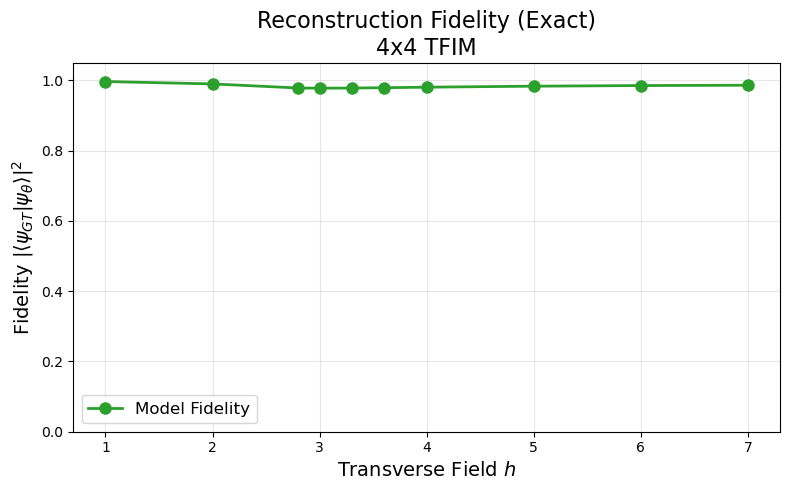

In [35]:
plt.figure(figsize=(8, 5))

plt.plot(df_fid["h"], df_fid["fidelity"], 'o-', color='C2', linewidth=2, markersize=8, label="Model Fidelity")

plt.xlabel(r"Transverse Field $h$", fontsize=14)
plt.ylabel(r"Fidelity $|\langle \psi_{GT} | \psi_{\theta} \rangle|^2$", fontsize=14)
plt.title(f"Reconstruction Fidelity (Exact)\n{SIDE_LENGTH}x{SIDE_LENGTH} TFIM", fontsize=16)
plt.ylim(0.0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()